In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import st_dep as st
import model_confs as confs


import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.roberta_conf
encoding_type = 'pos'
model_name = 'roberta'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = generic.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about'


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5840997285751516 	 Validation loss: 0.4143336187984984 	 
  1%|          | 574/57400 [01:42<2:17:11,  6.90it/s]
Epoch 2 	 Training loss: 0.40842606895684364 	 Validation loss: 0.3631980015059649 	 
  2%|▏         | 1148/57400 [03:22<2:44:21,  5.70it/s]
Epoch 3 	 Training loss: 0.37198078094978365 	 Validation loss: 0.3426153624461869 	 
  3%|▎         | 1722/57400 [05:03<2:27:44,  6.28it/s]
Epoch 4 	 Training loss: 0.35159074146469294 	 Validation loss: 0.33037211682836887 	 
  4%|▍         | 2296/57400 [06:43<2:34:15,  5.95it/s]
Epoch 5 	 Training loss: 0.33739197734444815 	 Validation loss: 0.32850293865648367 	 
  5%|▌         | 2870/57400 [08:24<2:32:46,  5.95it/s]
Epoch 6 	 Training loss: 0.3282762429440063 	 Validation loss: 0.31480174322249527 	 
  6%|▌         | 3444/57400 [10:05<2:36:58,  5.73it/s]
Epoch 7 	 Training loss: 0.3175465979642569 	 Validation loss: 0.3116297259674234 	 
  7%|▋         | 4018/57400 [11:46<2:31:16,  5.88it/s]
Epoch 8 	 Trai

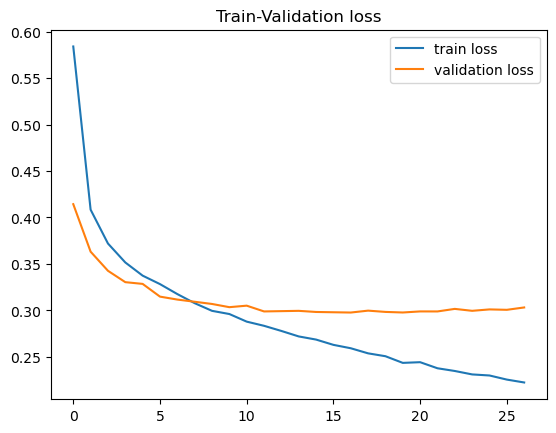

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [18]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.86, 'male': 0.859375, 'average': 0.8596874999999999}
precision {'female': 0.864321608040201, 'male': 0.8549222797927462, 'average': 0.8596219439164736}
f1 {'female': 0.8621553884711779, 'male': 0.8571428571428572, 'average': 0.8596491228070176}
accuracy 0.8596938775510204


Evaluación en el conjunto el conjunto to
recall {'female': 0.7034120734908137, 'male': 0.7104622871046229, 'average': 0.7069371802977182}
precision {'female': 0.6925064599483204, 'male': 0.7209876543209877, 'average': 0.706747057134654}
f1 {'female': 0.6979166666666666, 'male': 0.7156862745098039, 'average': 0.7068014705882353}
accuracy 0.7070707070707071


Evaluación en el conjunto el conjunto as
recall {'female': 0.6819407008086253, 'male': 0.7045454545454546, 'average': 0.69324307767704}
precision {'female': 0.6837837837837838, 'male': 0.7027707808564232, 'average': 0.6932772823201034}
f1 {'female': 0.6828609986504723, 'male': 0.703656998738966, 'a

In [19]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about2'


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5608184360460953 	 Validation loss: 0.39328407332048576 	 
  1%|          | 574/57400 [01:38<2:30:45,  6.28it/s]
Epoch 2 	 Training loss: 0.39775160598837955 	 Validation loss: 0.35539371608677556 	 
  2%|▏         | 1148/57400 [03:16<2:22:19,  6.59it/s]
Epoch 3 	 Training loss: 0.36864492551582617 	 Validation loss: 0.33755709357180835 	 
  3%|▎         | 1722/57400 [04:54<2:11:00,  7.08it/s]
Epoch 4 	 Training loss: 0.349329406324164 	 Validation loss: 0.32723050299337353 	 
  4%|▍         | 2296/57400 [06:33<2:26:01,  6.29it/s]
Epoch 5 	 Training loss: 0.33691282160190755 	 Validation loss: 0.318416617179321 	 
  5%|▌         | 2870/57400 [08:11<2:24:41,  6.28it/s]
Epoch 6 	 Training loss: 0.3258436757305358 	 Validation loss: 0.3117154470439685 	 
  6%|▌         | 3444/57400 [09:50<2:24:26,  6.23it/s]
Epoch 7 	 Training loss: 0.31560768794514993 	 Validation loss: 0.30816753991579604 	 
  7%|▋         | 4018/57400 [11:29<2:15:30,  6.57it/s]
Epoch 8 	 Trai

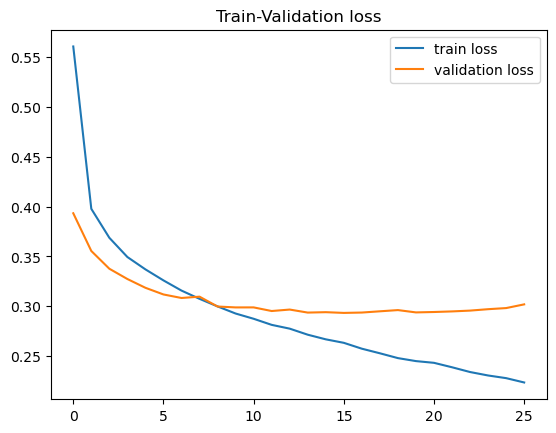

In [20]:

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p =train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [21]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.86, 'male': 0.859375, 'average': 0.8596874999999999}
precision {'female': 0.864321608040201, 'male': 0.8549222797927462, 'average': 0.8596219439164736}
f1 {'female': 0.8621553884711779, 'male': 0.8571428571428572, 'average': 0.8596491228070176}
accuracy 0.8596938775510204


Evaluación en el conjunto el conjunto to
recall {'female': 0.6955380577427821, 'male': 0.7274939172749392, 'average': 0.7115159875088606}
precision {'female': 0.7029177718832891, 'male': 0.7204819277108434, 'average': 0.7116998497970662}
f1 {'female': 0.6992084432717678, 'male': 0.7239709443099274, 'average': 0.7115896937908476}
accuracy 0.7121212121212122


Evaluación en el conjunto el conjunto as
recall {'female': 0.6792452830188679, 'male': 0.7045454545454546, 'average': 0.6918953687821612}
precision {'female': 0.6829268292682927, 'male': 0.7010050251256281, 'average': 0.6919659271969605}
f1 {'female': 0.6810810810810811, 'male': 0.7027707808564232

In [22]:
model =st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about3'


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5369014730644558 	 Validation loss: 0.39224346916554337 	 
  1%|          | 574/57400 [01:38<2:34:39,  6.12it/s]
Epoch 2 	 Training loss: 0.39548436004525694 	 Validation loss: 0.3565357231487662 	 
  2%|▏         | 1148/57400 [03:16<2:37:44,  5.94it/s]
Epoch 3 	 Training loss: 0.36371382312907574 	 Validation loss: 0.34044375939894533 	 
  3%|▎         | 1722/57400 [04:55<2:39:09,  5.83it/s]
Epoch 4 	 Training loss: 0.3475898915466947 	 Validation loss: 0.3269303251626128 	 
  4%|▍         | 2296/57400 [06:33<2:33:52,  5.97it/s]
Epoch 5 	 Training loss: 0.3336849056106411 	 Validation loss: 0.32056469028278933 	 
  5%|▌         | 2870/57400 [08:11<2:08:56,  7.05it/s]
Epoch 6 	 Training loss: 0.32218091249569786 	 Validation loss: 0.3149690890716294 	 
  6%|▌         | 3444/57400 [09:50<2:30:22,  5.98it/s]
Epoch 7 	 Training loss: 0.31440930431935843 	 Validation loss: 0.31717192419504714 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [11:28<2:29

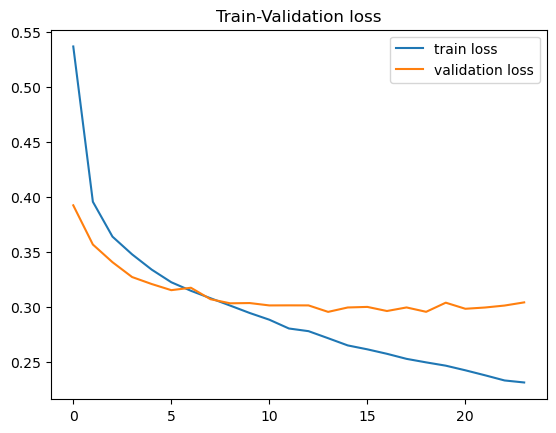

In [23]:

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [24]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.85, 'male': 0.8697916666666666, 'average': 0.8598958333333333}
precision {'female': 0.8717948717948718, 'male': 0.8477157360406091, 'average': 0.8597553039177405}
f1 {'female': 0.8607594936708861, 'male': 0.858611825192802, 'average': 0.859685659431844}
accuracy 0.8596938775510204


Evaluación en el conjunto el conjunto to
recall {'female': 0.6692913385826772, 'male': 0.7226277372262774, 'average': 0.6959595379044773}
precision {'female': 0.6910569105691057, 'male': 0.7021276595744681, 'average': 0.6965922850717869}
f1 {'female': 0.6799999999999999, 'male': 0.7122302158273383, 'average': 0.6961151079136692}
accuracy 0.696969696969697


Evaluación en el conjunto el conjunto as
recall {'female': 0.6576819407008087, 'male': 0.7222222222222222, 'average': 0.6899520814615154}
precision {'female': 0.6892655367231638, 'male': 0.6924939467312349, 'average': 0.6908797417271993}
f1 {'female': 0.6731034482758621, 'male': 0.70704573

Resultados finales

In [25]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.8596613016819598
f1 etiqueta male: 0.8576325131595055
f1 etiqueta female:  0.861690090204414


TO
Resultado global f1: 0.704835424097584
f1 etiqueta male: 0.7172958115490232
f1 etiqueta female:  0.6923750366461447


AS
Resultado global f1: 0.6917531738464502
f1 etiqueta male: 0.7044911716904285
f1 etiqueta female:  0.6790151760024719


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.8597569444444444
recall etiqueta male: 0.8628472222222222
recall etiqueta female:  0.8566666666666667


TO
Resultado global recall: 0.7048042352370187
recall etiqueta male: 0.7201946472019465
recall etiqueta female:  0.689413823272091


AS
Resultado global recall: 0.6916968426402389
recall etiqueta male: 0.7104377104377104
recall etiqueta female:  0.6729559748427673


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.8596663972502292
precision etiqueta male: 0.8525200985420338
precision etiqueta female:  0.8668

# TO

In [26]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [27]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6948763249435491 	 Validation loss: 0.6918318514096535 	 
  1%|          | 574/57400 [01:39<2:36:08,  6.07it/s]
Epoch 2 	 Training loss: 0.6950334641783911 	 Validation loss: 0.694006869348429 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:18<4:04:42,  3.83it/s]
Epoch 3 	 Training loss: 0.6945507610508789 	 Validation loss: 0.6939222267118551 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [04:56<2:32:20,  6.09it/s]
Epoch 4 	 Training loss: 0.6943309986217512 	 Validation loss: 0.6930095583705579 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [06:35<2:40:58,  5.70it/s]
Epoch 5 	 Training loss: 0.6942921431430126 	 Validation loss: 0.6931608056617995 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [08:14<2:33:21,  5.93it/s]
Epoch 6 	 Training loss: 0.693924617268898 	 Validation loss: 0.6931630625563153 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [09:52<2:25:05,  6.20it/s]
Epoch 7 	 Training

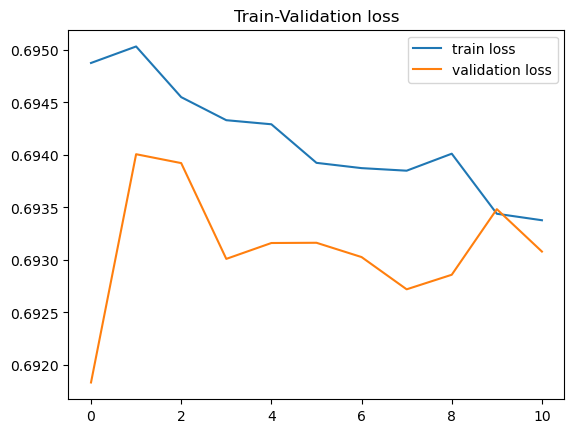

In [28]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [29]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.875, 'male': 0.1015625, 'average': 0.48828125}
precision {'female': 0.5035971223021583, 'male': 0.43820224719101125, 'average': 0.4708996847465847}
f1 {'female': 0.639269406392694, 'male': 0.16490486257928122, 'average': 0.40208713448598765}
accuracy 0.4961734693877551


Evaluación en el conjunto el conjunto to
recall {'female': 0.8818897637795275, 'male': 0.16058394160583941, 'average': 0.5212368526926835}
precision {'female': 0.4933920704845815, 'male': 0.5945945945945946, 'average': 0.543993332539588}
f1 {'female': 0.6327683615819208, 'male': 0.2528735632183908, 'average': 0.4428209624001558}
accuracy 0.5075757575757576


Evaluación en el conjunto el conjunto as
recall {'female': 0.9353099730458221, 'male': 0.10101010101010101, 'average': 0.5181600370279615}
precision {'female': 0.49359886201991465, 'male': 0.625, 'average': 0.5592994310099573}
f1 {'female': 0.6461824953445064, 'male': 0.1739130434782609, 'average': 0

In [30]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to2'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6940678611449663 	 Validation loss: 0.6935526304325815 	 
  1%|          | 574/57400 [01:39<2:36:28,  6.05it/s]
Epoch 2 	 Training loss: 0.6939242668060476 	 Validation loss: 0.6928818953239312 	 
  2%|▏         | 1148/57400 [03:18<2:31:59,  6.17it/s]
Epoch 3 	 Training loss: 0.69374386784507 	 Validation loss: 0.6934544777466078 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [04:57<2:29:18,  6.22it/s]
Epoch 4 	 Training loss: 0.69358654439657 	 Validation loss: 0.6924231163525986 	 
  4%|▍         | 2296/57400 [06:36<2:22:08,  6.46it/s]
Epoch 5 	 Training loss: 0.693542986173663 	 Validation loss: 0.6932527725979433 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:15<2:12:57,  6.84it/s]
Epoch 6 	 Training loss: 0.6934739746906201 	 Validation loss: 0.6920345506425631 	 
  6%|▌         | 3444/57400 [09:54<2:31:19,  5.94it/s]
Epoch 7 	 Training loss: 0.6937005084773805 	 Validation loss: 0.6932253423383681 	 

1 epoch without improv

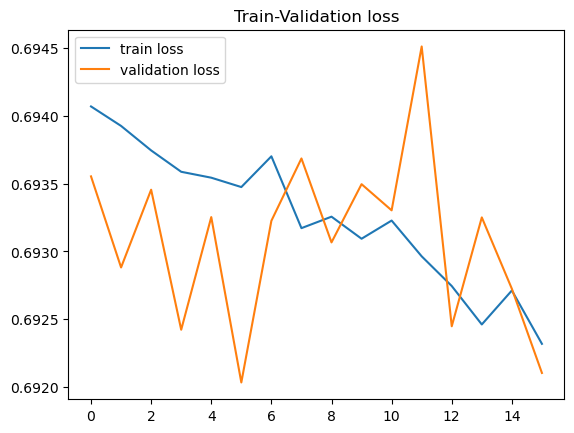

In [31]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [32]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.925, 'male': 0.09895833333333333, 'average': 0.5119791666666667}
precision {'female': 0.5167597765363129, 'male': 0.5588235294117647, 'average': 0.5377916529740387}
f1 {'female': 0.6630824372759858, 'male': 0.16814159292035397, 'average': 0.4156120150981699}
accuracy 0.5204081632653061


Evaluación en el conjunto el conjunto to
recall {'female': 0.94750656167979, 'male': 0.06569343065693431, 'average': 0.5065999961683622}
precision {'female': 0.48456375838926175, 'male': 0.574468085106383, 'average': 0.5295159217478224}
f1 {'female': 0.6412078152753109, 'male': 0.11790393013100438, 'average': 0.37955587270315766}
accuracy 0.4898989898989899


Evaluación en el conjunto el conjunto as
recall {'female': 0.9514824797843666, 'male': 0.06313131313131314, 'average': 0.5073068964578399}
precision {'female': 0.48756906077348067, 'male': 0.5813953488372093, 'average': 0.534482204805345}
f1 {'female': 0.6447488584474886, 'male': 0.

In [33]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to3'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6946527672353937 	 Validation loss: 0.6930458424455028 	 
  1%|          | 574/57400 [01:39<2:42:01,  5.85it/s]
Epoch 2 	 Training loss: 0.6940166645972156 	 Validation loss: 0.6922488788426933 	 
  2%|▏         | 1148/57400 [03:17<2:37:29,  5.95it/s]
Epoch 3 	 Training loss: 0.6937688465525464 	 Validation loss: 0.6921567108671544 	 
  3%|▎         | 1722/57400 [04:56<2:34:08,  6.02it/s]
Epoch 4 	 Training loss: 0.6937919184305942 	 Validation loss: 0.6928712695331897 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:35<2:44:21,  5.59it/s]
Epoch 5 	 Training loss: 0.6936374471785715 	 Validation loss: 0.6928387526738442 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:14<4:03:07,  3.74it/s]
Epoch 6 	 Training loss: 0.6935343257433861 	 Validation loss: 0.6928694844245911 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [09:53<2:23:07,  6.28it/s]
Epoch 7 	 Training loss: 0.6935709457364232 	 Validation loss: 0.692426850

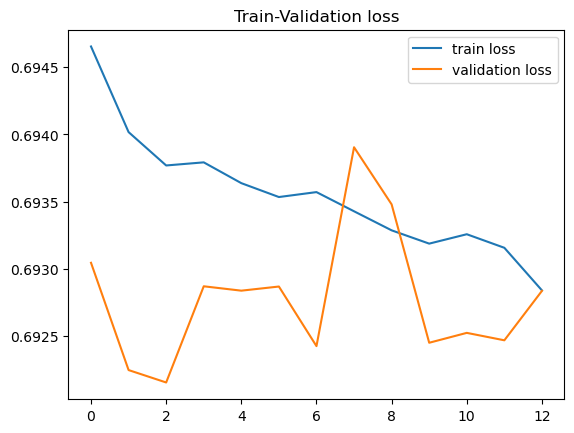

In [34]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [35]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8125, 'male': 0.1953125, 'average': 0.50390625}
precision {'female': 0.5126182965299685, 'male': 0.5, 'average': 0.5063091482649842}
f1 {'female': 0.6286266924564798, 'male': 0.2808988764044944, 'average': 0.4547627844304871}
accuracy 0.5102040816326531


Evaluación en el conjunto el conjunto to
recall {'female': 0.7926509186351706, 'male': 0.1654501216545012, 'average': 0.4790505201448359}
precision {'female': 0.4682170542635659, 'male': 0.46258503401360546, 'average': 0.4654010441385857}
f1 {'female': 0.5886939571150098, 'male': 0.24372759856630824, 'average': 0.416210777840659}
accuracy 0.4671717171717172


Evaluación en el conjunto el conjunto as
recall {'female': 0.7897574123989218, 'male': 0.19444444444444445, 'average': 0.4921009284216831}
precision {'female': 0.47875816993464054, 'male': 0.4967741935483871, 'average': 0.4877661817415138}
f1 {'female': 0.5961342828077315, 'male': 0.27949183303085295, 'average': 0.

Resultados finales

In [36]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.4241539780048816
f1 etiqueta male: 0.2046484439680432
f1 etiqueta female:  0.6436595120417199


TO
Resultado global f1: 0.4128625376479908
f1 etiqueta male: 0.20483503063856778
f1 etiqueta female:  0.6208900446574138


AS
Resultado global f1: 0.4090609549182919
f1 etiqueta male: 0.18910003097000833
f1 etiqueta female:  0.6290218788665756


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5013888888888889
recall etiqueta male: 0.13194444444444445
recall etiqueta female:  0.8708333333333333


TO
Resultado global recall: 0.5022957896686272
recall etiqueta male: 0.1305758313057583
recall etiqueta female:  0.8740157480314961


AS
Resultado global recall: 0.5058559539691615
recall etiqueta male: 0.11952861952861953
recall etiqueta female:  0.8921832884097035


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5050001619952026
precision etiqueta male: 0.4990085922009253
precision etiqueta female: 

# AS

In [37]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [38]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as1'


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6991082822404256 	 Validation loss: 0.6919733578875914 	 
  1%|          | 574/57400 [01:39<2:35:45,  6.08it/s]
Epoch 2 	 Training loss: 0.6953333312003039 	 Validation loss: 0.6902460587226739 	 
  2%|▏         | 1148/57400 [03:17<2:38:49,  5.90it/s]
Epoch 3 	 Training loss: 0.6931084180542816 	 Validation loss: 0.6911737868341349 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [04:56<2:30:54,  6.15it/s]
Epoch 4 	 Training loss: 0.6904967862346861 	 Validation loss: 0.6904697125240907 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [06:34<2:25:59,  6.29it/s]
Epoch 5 	 Training loss: 0.6888660354481342 	 Validation loss: 0.6905579051728976 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [08:13<2:34:38,  5.88it/s]
Epoch 6 	 Training loss: 0.6865481182880934 	 Validation loss: 0.6907514576184548 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [09:51<2:21:09,  6.37it/s]
Epoch 7 	 Training loss: 0.6845224387554342 	

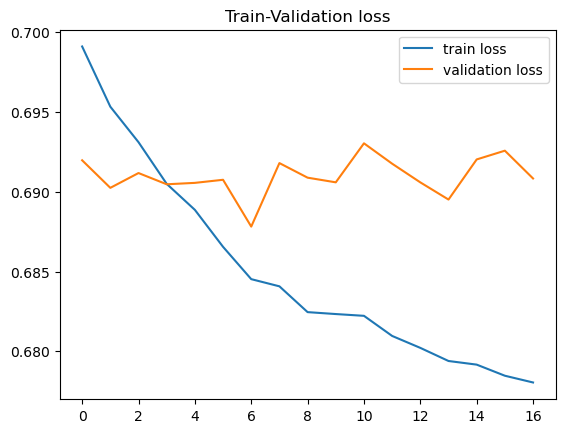

In [39]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [40]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.6, 'male': 0.7682291666666666, 'average': 0.6841145833333333}
precision {'female': 0.729483282674772, 'male': 0.6483516483516484, 'average': 0.6889174655132102}
f1 {'female': 0.6584362139917695, 'male': 0.7032181168057211, 'average': 0.6808271653987453}
accuracy 0.6823979591836735


Evaluación en el conjunto el conjunto to
recall {'female': 0.5879265091863517, 'male': 0.8491484184914841, 'average': 0.7185374638389179}
precision {'female': 0.7832167832167832, 'male': 0.6897233201581028, 'average': 0.736470051687443}
f1 {'female': 0.6716641679160419, 'male': 0.7611777535441657, 'average': 0.7164209607301038}
accuracy 0.7234848484848485


Evaluación en el conjunto el conjunto as
recall {'female': 0.8059299191374663, 'male': 0.8484848484848485, 'average': 0.8272073838111573}
precision {'female': 0.8328690807799443, 'male': 0.8235294117647058, 'average': 0.8281992462723251}
f1 {'female': 0.8191780821917808, 'male': 0.83582089

In [41]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as2'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6942172215583017 	 Validation loss: 0.6931543521961924 	 
  1%|          | 574/57400 [01:38<2:36:06,  6.07it/s]
Epoch 2 	 Training loss: 0.6932652754650714 	 Validation loss: 0.6932040261009992 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:17<2:33:20,  6.11it/s]
Epoch 3 	 Training loss: 0.6907035950376597 	 Validation loss: 0.6936447398137238 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [04:55<2:13:06,  6.97it/s]
Epoch 4 	 Training loss: 0.6888443250273993 	 Validation loss: 0.6911270840693329 	 
  4%|▍         | 2296/57400 [06:34<2:37:52,  5.82it/s]
Epoch 5 	 Training loss: 0.6866076891845942 	 Validation loss: 0.6932820152428191 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:14<4:06:24,  3.69it/s]
Epoch 6 	 Training loss: 0.6849441936414832 	 Validation loss: 0.6896813562360861 	 
  6%|▌         | 3444/57400 [09:54<2:32:14,  5.91it/s]
Epoch 7 	 Training loss: 0.6837780460040328 	 Validation loss: 0.690242792

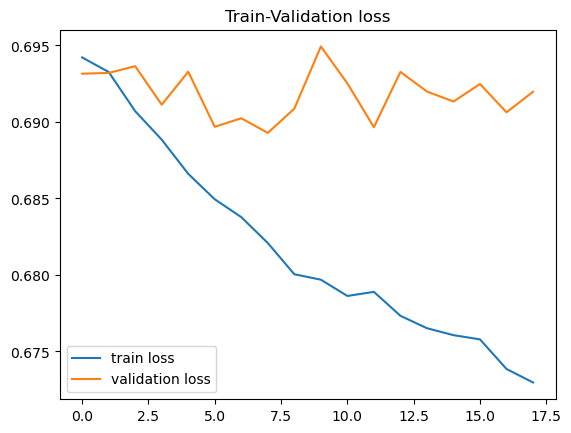

In [42]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [43]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.5225, 'male': 0.7317708333333334, 'average': 0.6271354166666667}
precision {'female': 0.6698717948717948, 'male': 0.5953389830508474, 'average': 0.6326053889613211}
f1 {'female': 0.5870786516853932, 'male': 0.6565420560747663, 'average': 0.6218103538800798}
accuracy 0.625


Evaluación en el conjunto el conjunto to
recall {'female': 0.6167979002624672, 'male': 0.8223844282238443, 'average': 0.7195911642431557}
precision {'female': 0.762987012987013, 'male': 0.6983471074380165, 'average': 0.7306670602125147}
f1 {'female': 0.6821480406386067, 'male': 0.7553072625698325, 'average': 0.7187276516042196}
accuracy 0.7234848484848485


Evaluación en el conjunto el conjunto as
recall {'female': 0.7897574123989218, 'male': 0.8232323232323232, 'average': 0.8064948678156225}
precision {'female': 0.8071625344352618, 'male': 0.806930693069307, 'average': 0.8070466137522844}
f1 {'female': 0.7983651226158038, 'male': 0.815, 'average': 0.

In [44]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as3'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6949022444490772 	 Validation loss: 0.6933542348570743 	 
  1%|          | 574/57400 [01:39<2:32:43,  6.20it/s]
Epoch 2 	 Training loss: 0.6943498234092567 	 Validation loss: 0.6932547961251211 	 
  2%|▏         | 1148/57400 [03:18<2:28:21,  6.32it/s]
Epoch 3 	 Training loss: 0.6938331833284491 	 Validation loss: 0.6930905045089075 	 
  3%|▎         | 1722/57400 [04:57<2:35:19,  5.97it/s]
Epoch 4 	 Training loss: 0.6931054679358878 	 Validation loss: 0.6902571835760343 	 
  4%|▍         | 2296/57400 [06:36<2:34:05,  5.96it/s]
Epoch 5 	 Training loss: 0.6912177634986851 	 Validation loss: 0.6912110518600981 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:14<2:31:55,  5.98it/s]
Epoch 6 	 Training loss: 0.6893882191762691 	 Validation loss: 0.6894534876791097 	 
  6%|▌         | 3444/57400 [09:54<2:33:28,  5.86it/s]
Epoch 7 	 Training loss: 0.6885633492511324 	 Validation loss: 0.6914243960784654 	 

1 epoch without improvement
  7%|▋         | 4

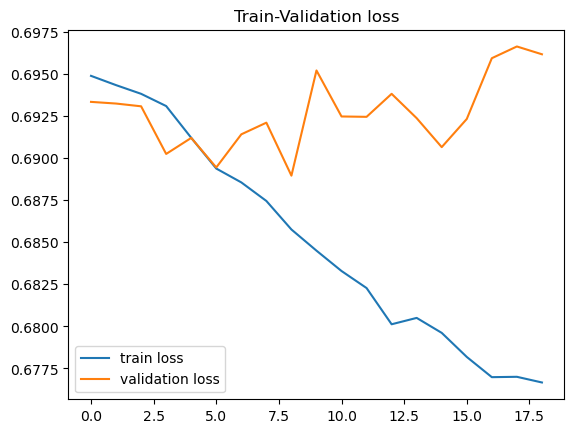

In [45]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [46]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.5375, 'male': 0.7395833333333334, 'average': 0.6385416666666667}
precision {'female': 0.6825396825396826, 'male': 0.605543710021322, 'average': 0.6440416962805022}
f1 {'female': 0.6013986013986015, 'male': 0.6658851113716295, 'average': 0.6336418563851155}
accuracy 0.6364795918367347


Evaluación en el conjunto el conjunto to
recall {'female': 0.5196850393700787, 'male': 0.7956204379562044, 'average': 0.6576527386631416}
precision {'female': 0.7021276595744681, 'male': 0.6411764705882353, 'average': 0.6716520650813518}
f1 {'female': 0.5972850678733032, 'male': 0.7100977198697067, 'average': 0.653691393871505}
accuracy 0.6628787878787878


Evaluación en el conjunto el conjunto as
recall {'female': 0.6954177897574124, 'male': 0.7474747474747475, 'average': 0.72144626861608}
precision {'female': 0.7206703910614525, 'male': 0.7237163814180929, 'average': 0.7221933862397727}
f1 {'female': 0.7078189300411522, 'male': 0.7354037

Resultados finales

In [47]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.6454264585546469
f1 etiqueta male: 0.6752150947507056
f1 etiqueta female:  0.6156378223585881


TO
Resultado global f1: 0.6962800020686094
f1 etiqueta male: 0.7421942453279017
f1 etiqueta female:  0.6503657588093172


AS
Resultado global f1: 0.7852644595131999
f1 etiqueta male: 0.7954082074101542
f1 etiqueta female:  0.7751207116162456


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.6454264585546469
recall etiqueta male: 0.6752150947507056
recall etiqueta female:  0.6156378223585881


TO
Resultado global recall: 0.6962800020686094
recall etiqueta male: 0.7421942453279017
recall etiqueta female:  0.6503657588093172


AS
Resultado global recall: 0.7852644595131999
recall etiqueta male: 0.7954082074101542
recall etiqueta female:  0.7751207116162456


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.6454264585546469
precision etiqueta male: 0.6752150947507056
precision etiqueta female:  0.6